# Logistic Regression

In [1]:
#!pip install imblearn

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import RandomOverSampler, SMOTE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from src import log_reg_utils

## UDF

## Import Dataset

In [3]:
accidents = pd.read_csv('data/accidents.csv', index_col=0)

In [4]:
accidents.head(2)

,RD_NO,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,...,at_intersection,was_non_functioning_device,is_day,is_evening,is_morning,is_night,is_fall,is_spring,is_summer,is_winter
0,JC343143,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,...,0,0,1,0,0,0,0,0,1,0
5,JC194776,03/21/2019 10:50:00 PM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,"DARKNESS, LIGHTED ROAD",TURNING,NOT DIVIDED,4.0,...,0,0,0,0,0,1,0,1,0,0


## Process Data for Model

In [5]:
X = accidents[['is_pedestrian',
               'has_stop_sign_or_traffic_light',
               'is_parked',
               'has_no_controls',
               'is_cyclist']]



y = accidents['is_fatal_or_incap']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=3)

In [6]:
scaler = MinMaxScaler()
# scaler = StandardScaler()

scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
#oversampler = RandomOverSampler(sampling_strategy=0.75, random_state=3)
oversampler = SMOTE(sampling_strategy=0.75, random_state=3)

X_over, y_over = oversampler.fit_resample(X_train_scaled, y_train)

### Hyperparameter Tuning

In [8]:
#solvers = ['newton-cg', 'lbfgs', 'liblinear']
c_values =  [0.01, 0.1, 1.0, 10, 100]
params_grid = dict(C=c_values)

In [9]:
log_reg = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, fit_intercept=True, random_state=3)

clf = GridSearchCV(log_reg, params_grid, cv=5, verbose=0, scoring='recall')

best_model = clf.fit(X_over, y_over)

In [10]:
print('Best C: ', best_model.best_estimator_.get_params()['C'])

Best C:  10


### Train and Predict

In [50]:
penalty = 'l1'
solver='saga'
c=1.0

log_reg = LogisticRegression(penalty=penalty, solver=solver, C=c, max_iter=1000, fit_intercept=True, random_state=3)
log_reg.fit(X_over, y_over)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
print('\n')
print('Recall (Scores FN): ', round(recall_score(y_test, y_pred), 4))
print('Precision (Scores FP): ', round(precision_score(y_test, y_pred), 4))
print('AUC Score: ', round(roc_auc_score(y_test, y_prob), 4))

[[51750  5800]
 [  600   465]]


Recall (Scores FN):  0.4366
Precision (Scores FP):  0.0742
AUC Score:  0.7409


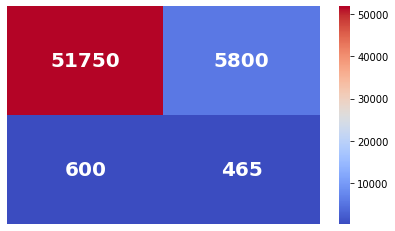

In [51]:
plt.figure(figsize=(7,4))
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, annot_kws={'size': 20, 'fontweight':'bold'}, fmt='d',
                 xticklabels=False, yticklabels=False);
#plt.savefig('img/cf_matrix.png', bbox_inches='tight')

In [52]:
coef_summary = pd.DataFrame()
coef_summary['feature_name'] = pd.Series(X.columns)
coef_summary['log_reg_coef'] = pd.Series(log_reg.coef_[0])
coef_summary.sort_values('log_reg_coef', inplace = True, ascending=False)
coef_summary

,feature_name,log_reg_coef
9,POSTED_SPEED_LIMIT,3.624411
1,involved_pedest_cycle,2.522580
10,was_head_on,1.116474
4,is_night,0.458669
2,at_stop_sign_or_traffic_light,0.231601
0,is_weekend,0.159704
5,is_rain,0.111316
8,is_fall,0.007117
7,is_winter,-0.030453
3,is_day,-0.131076


In [53]:
print('Intercept: ', log_reg.intercept_[0])

Intercept:  -2.2374766309657805


### Test for Multicolinearity

In [54]:
type(X_over)
y_over.shape

(402531,)

In [55]:
X_over_incl_const = sm.add_constant(X_over)
model = sm.Logit(y_over, X_over_incl_const)
results = model.fit(method='cg')
results.summary()

         Current function value: 0.568518
         Iterations: 35
         Function evaluations: 102
         Gradient evaluations: 102


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:      is_fatal_or_incap   No. Observations:               402531
Model:                          Logit   Df Residuals:                   402518
Method:                           MLE   Df Model:                           12
Date:                Tue, 02 Feb 2021   Pseudo R-squ.:                  0.1675
Time:                        04:52:08   Log-Likelihood:            -2.2885e+05
converged:                      False   LL-Null:                   -2.7489e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2195      0.025    -90.403      0.000      -2.268      -2.171
x1             0.1616      0.008     19.938      0.000       0.146       0.177
x2             2.5192      0.012    202.907      0.000       2.495       2.544
x3             0.2296      0.008     30.569      0.000       0.215       0.244
x4            -0.1332      0.008    -16.398      0.000      -0.149      -0.117
x5             0.4605      0.010     44.434      0.000       0.440       0.481
x6             0.1101      0.012      9.388      0.000       0.087       0.133
x7            -0.3239      0.019    -16.736      0.000      -0.362      -0.286
x8            -0.0300      0.009     -3.327      0.001      -0.048      -0.012
x9             0.0075      0.009      0.873      0.383      -0.009       0.024
x10            3.5841      0.054     66.744      0.000       3.479       3.689
x11            1.0701      0.031     34.327      0.000       1.009       1.131
x12           -0.8864      0.012    -72.677      0.000      -0.910      -0.863
==============================================================================
"""

In [56]:
X_over_df = pd.DataFrame(X_over, columns=X.columns)
log_reg_utils.calc_vif(X_over_df)

,features,VIF
0,is_weekend,1.426986
1,involved_pedest_cycle,1.232462
2,at_stop_sign_or_traffic_light,1.950757
3,is_day,2.241828
4,is_night,1.591104
5,is_rain,1.138169
6,is_sleet_snow,1.108883
7,is_winter,1.696152
8,is_fall,1.687764
9,POSTED_SPEED_LIMIT,5.431292
